<a href="https://colab.research.google.com/github/dldowning/Fall2022-5222/blob/main/Downing_Roberts_5222_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [579]:
import pandas as pd
import numpy as np
from statistics import mean
import nltk
from google.colab import files
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
import string
import random
import seaborn as sns
from nltk.corpus import stopwords
import csv
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Creating dataframe

In [580]:
URL = "https://drive.google.com/uc?export=download&id=1C8ARH_yok3uOvirD_oKvgEmAR22SuC9R"
response = requests.get(URL)
open("train_text_labels.csv", "wb").write(response.content)

5123208

In [581]:
URL = "https://drive.google.com/uc?export=download&id=1z0URnDJ8ck38mQ4CvHi5TUkly8e46glP"
response = requests.get(URL)
open("test_text.txt", "wb").write(response.content)

1156877

In [582]:
URL = "https://drive.google.com/uc?export=download&id=1xWQ2Lpf866Be4OR8J-cJHuY1S25dWppf"
response = requests.get(URL)
open("test_labels.txt", "wb").write(response.content)

36850

In [583]:
df0 = pd.read_csv("/content/train_text_labels.csv", header=None)
df0.columns = ['Twitter', 'Label']
len(df0)

45615

In [584]:
dft = pd.read_csv("/content/test_text.txt", sep="\n", header=None, quoting=csv.QUOTE_NONE)
dft.columns = ['Twitter']
len(dft)


12284

In [585]:
dftl = pd.read_csv("/content/test_labels.txt", sep="\n", header=None)
dftl.columns = ['Label']
len(dftl)


12284

In [586]:
dft['Label']=dftl['Label']
dft.head()

,Twitter,Label
0,@user @user what do these '1/2 naked pics' hav...,1
1,OH: “I had a blue penis while I was this” [pla...,1
2,"@user @user That's coming, but I think the vic...",1
3,I think I may be finally in with the in crowd ...,2
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0


In [587]:
df0['Label'].value_counts()
#0	negative
#1	neutral
#2	positive

1    20673
2    17849
0     7093
Name: Label, dtype: int64

In [588]:
#dropping the neutrals
df = df0[df0['Label'] != 1]
df.loc[df.Label == 2, 'Label'] = 1
df=df.reset_index(drop=True)
len(df)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


24942

In [589]:
dft = dft[dft['Label'] != 1]
dft=dft.reset_index(drop=True)
dft.loc[dft.Label == 2, 'Label'] = 1
len(df)
len(dft)

6347

In [590]:
def tweetcleanandtoke(dataframe,colname,newcolname):
  stop = stopwords.words('english')
  pattern_a = r'[^A-Za-z0-9]+' #non-alphanumeric
  pattern_b = r'\b\w{1,1}\b' #repeated words
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)

  for i in range(0, len(dataframe.index)):                       
    dataframe[colname].values[i] = dataframe[colname].values[i].lower()
    dataframe[colname].values[i] = dataframe[colname].values[i].replace('@user', '')
    dataframe[colname].values[i] = re.sub(emoji_pattern, '', dataframe[colname].values[i])
    dataframe[colname].values[i] = re.sub(pattern_a, ' ', dataframe[colname].values[i])
    dataframe[colname].values[i] = re.sub(pattern_b, '', dataframe[colname].values[i])
    

  dataframe[colname] = dataframe[colname].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  rowname = dataframe[colname].name
  dataframe[newcolname]=0
  dataframe[newcolname] = dataframe.apply(lambda row: nltk.word_tokenize(row[rowname]), axis=1)

  return dataframe
  

In [591]:
df=tweetcleanandtoke(df,'Twitter','Twitter_tokens')
dft=tweetcleanandtoke(df,'Twitter','Twitter_tokens')

In [592]:
df['Token_len']=df['Twitter_tokens'].apply(len)
dft['Token_len']=dft['Twitter_tokens'].apply(len)



In [593]:
#Evaluating the tokens for some EDA, also verifying I have no length 0
list_of_lengths=[]
less_than_9_len=[]
for i in range (0, len(df)):
  try:
    list_of_lengths.append(len(df['Twitter_tokens'][i]));
  except:
    pass
  try:
    if len(df['Twitter_tokens'][i]) < 9:
      less_than_9_len.append(str(i));
  except:
    pass
print("These stats are for the training set")
print("The min length is: " + str(min(list_of_lengths)))
print("The max length is: " + str(max(list_of_lengths)))
print("The mean length is: " + str(mean(list_of_lengths)))
print("The number of tweets with less than 9 tokens is: " + str(len(less_than_9_len)))

These stats are for the training set
The min length is: 1
The max length is: 26
The mean length is: 11.502004650789832
The number of tweets with less than 9 tokens is: 4506


In [594]:
list_of_lengths=[]
less_than_9_len=[]
for i in range (0, len(dft)):
  try:
    list_of_lengths.append(len(dft['Twitter_tokens'][i]));
  except:
    pass
  try:
    if len(dft['Twitter_tokens'][i]) < 9:
      less_than_9_len.append(str(i));
  except:
    pass
print("These stats are for the testing set")
print("The min test length is: " + str(min(list_of_lengths)))
print("The max test length is: " + str(max(list_of_lengths)))
print("The mean test length is: " + str(mean(list_of_lengths)))
print("The number of test tweets with less than 9 tokens is: " + str(len(less_than_9_len)))

These stats are for the testing set
The min test length is: 1
The max test length is: 26
The mean test length is: 11.502004650789832
The number of test tweets with less than 9 tokens is: 4506


#Loading and extracting TSVs

In [595]:
!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_freq.zip
!echo "N"| unzip /content/socialsent_hist_freq.zip

--2022-11-12 20:34:09--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_freq.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 521987 (510K) [application/zip]
Saving to: ‘socialsent_hist_freq.zip.4’

socialsent_hist_fre 100%[===================>] 509.75K   289KB/s    in 1.8s    

2022-11-12 20:34:11 (289 KB/s) - ‘socialsent_hist_freq.zip.4’ saved [521987/521987]

Archive:  /content/socialsent_hist_freq.zip
replace frequent_words/1850.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [596]:
!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_adj.zip
!echo "N"| unzip /content/socialsent_hist_adj.zip

--2022-11-12 20:34:12--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_hist_adj.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201855 (197K) [application/zip]
Saving to: ‘socialsent_hist_adj.zip.4’

socialsent_hist_adj 100%[===================>] 197.12K   207KB/s    in 1.0s    

2022-11-12 20:34:13 (207 KB/s) - ‘socialsent_hist_adj.zip.4’ saved [201855/201855]

Archive:  /content/socialsent_hist_adj.zip
replace adjectives/1850.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [597]:
df_2000adj = pd.read_csv("/content/adjectives/2000.tsv", sep="\t", header=None)
df_2000adj.columns = ['Word', 'Sentiment', 'Std']
df_2000freq = pd.read_csv("/content/frequent_words/2000.tsv", sep="\t", header=None)
df_2000freq.columns = ['Word', 'Sentiment', 'Std']

In [598]:
!wget https://nlp.stanford.edu/projects/socialsent/files/socialsent_subreddits.zip
!echo "N"| unzip /content/socialsent_subreddits.zip

--2022-11-12 20:34:13--  https://nlp.stanford.edu/projects/socialsent/files/socialsent_subreddits.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15659374 (15M) [application/zip]
Saving to: ‘socialsent_subreddits.zip.4’

socialsent_subreddi 100%[===================>]  14.93M  2.74MB/s    in 5.7s    

2022-11-12 20:34:20 (2.61 MB/s) - ‘socialsent_subreddits.zip.4’ saved [15659374/15659374]

Archive:  /content/socialsent_subreddits.zip
replace subreddits/.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [599]:
list_files = ['3DS.tsv', 
'4chan.tsv',
'2007scape.tsv',
'ACTrade.tsv',
'amiugly.tsv',
'BabyBumps.tsv',
'baseball.tsv',
'canada.tsv',
'CasualConversation.tsv',
'DarkNetMarkets.tsv',
'darksouls.tsv',
'elderscrollsonline.tsv',
'Eve.tsv',
'Fallout.tsv',
'fantasyfootball.tsv',
'GameDeals.tsv',
'gamegrumps.tsv',
'halo.tsv',
'Homebrewing.tsv',
'IAmA.tsv',
'india.tsv',
'jailbreak.tsv',
'Jokes.tsv',
'KerbalSpaceProgram.tsv',
'keto.tsv',
'leagueoflegends.tsv',
'Libertarian.tsv',
'magicTCG.tsv',
'MakeupAddiction.tsv',
'Naruto.tsv',
'nba.tsv',
'oculus.tsv',
'OkCupid.tsv',
'Parenting.tsv',
'pathofexile.tsv',
'raisedbynarcissists.tsv',
'Random_Acts_Of_Amazon.tsv',
'science.tsv',
'Seattle.tsv',
'TalesFromRetail.tsv',
'talesfromtechsupport.tsv',
'ultrahardcore.tsv',
'videos.tsv',
'Warthunder.tsv',
'whowouldwin.tsv',
'xboxone.tsv',
'yugioh.tsv',
]

In [600]:
list_dicts=[]
for i in range(0,len(list_files)):
    dfname='df_'+str(list_files[i])
    dfname=dfname.replace('.tsv','')
    path="/content/subreddits/" + list_files[i]
    dataframe = pd.read_csv(path, sep="\t", header=None)
    dataframe.columns = ['Word', 'Sentiment', 'Std']
    dataframe=dataframe.drop(columns=['Std'])
    list_dicts.append(dict(dataframe.values))

In [601]:
#combine dictionaries
def dict_merger(dict1, dict2):
    new_dict = {**dict1, **dict2}
    return new_dict

In [602]:
df_2000adj=df_2000adj.drop(columns='Std')
feature1=dict(df_2000adj.values)
df_2000freq=df_2000freq.drop(columns='Std')
feature2=dict(df_2000freq.values)

In [603]:
feature3 = {}
for i in range(0, 8):
  feature3=dict_merger(feature3,list_dicts[i])

feature4 = {}
for i in range(8, 16):
  feature4=dict_merger(feature4,list_dicts[i])

feature5 = {}
for i in range(16, 23):
  feature5=dict_merger(feature5,list_dicts[i])

feature6 = {}
for i in range(23, 29):
  feature6=dict_merger(feature6,list_dicts[i])

feature7 = {}
for i in range(29, 34):
  feature7=dict_merger(feature7,list_dicts[i])

feature8 = {}
for i in range(34, 41):
  feature8=dict_merger(feature8,list_dicts[i])

feature9 = {}
for i in range(41, 47):
  feature9=dict_merger(feature9,list_dicts[i])





#Extracting features

In [668]:
#one thing that boosted my scores was instead of taking one word per feature, I summed 9 words per feature
#I took words at random and oversampled shorter tweets. boosted the F1 score by letting randomization try to hit a good token
def lookups(row):
  lookup_index=row.name
  #print("This is the lookup_index: " + str(lookup_index))
  range_len=(df['Token_len'][lookup_index])
  #print("This is the range_len: " + str(range_len))
  score=[]
  for i in range(0, 9):
    #print("Starting the for loop at: " + str(i))
    token=random.randint(0, range_len) 
    token -= 1
    #print("The token is: " + str(token))
    word_tok=df.iloc[lookup_index, 2][token]
    #print("The word_tok is: " + str(word_tok))
    try:
      score.append(current_dict[word_tok])
    except:
      pass
  try:
      sum_score=sum(score)
  except:
      sum_score=0
  return sum_score

def lookupst(row):
  lookup_index=row.name
  #print("This is the lookup_index: " + str(lookup_index))
  range_len=(dft['Token_len'][lookup_index])
  #print("This is the range_len: " + str(range_len))
  score=[]
  for i in range(0, 9):
    #print("Starting the for loop at: " + str(i))
    token=random.randint(0, range_len) 
    token -= 1
    #print("The token is: " + str(token))
    word_tok=dft.iloc[lookup_index, 2][token]
    #print("The word_tok is: " + str(word_tok))
    try:
      score.append(current_dict[word_tok])
    except:
      pass
  try:
      sum_score=sum(score)
  except:
      sum_score=0
  return sum_score

def wordlengther(row):
    index=row.name
    token_list=df['Twitter_tokens'][index]
    longest_word=1
    for word in token_list:
        if longest_word<len(word):
          longest_word=len(word)
    log_long=np.log10(longest_word)
    return log_long

def wordfiver(row):
    index=row.name
    token_list=df['Twitter_tokens'][index]
    five_counts=1
    for word in token_list:
        if len(word)>=5:
          five_counts+=1
    log_five=np.log10(five_counts)
    return log_five

def wordlengthert(row):
    index=row.name
    token_list=dft['Twitter_tokens'][index]
    longest_word=1
    for word in token_list:
        if longest_word<len(word):
          longest_word=len(word)
    log_long=np.log10(longest_word)
    return log_long

def wordfivert(row):
    index=row.name
    token_list=dft['Twitter_tokens'][index]
    five_counts=1
    for word in token_list:
        if len(word)>=5:
          five_counts+=1
    log_five=np.log10(five_counts)
    return log_five

def mostpos(row):  #need the negative version too, mostneg
    index=row.name
    token_list=df['Twitter_tokens'][index]
    max_value=0
    for word in token_list:
      try: pos_value=feature3[word]   #replace with super dictionary
      except: pos_value=0
      if max_value<pos_value:
        max_value=pos_value
    return max_value

In [666]:
df['feature24']=0
df['feature24']=df.apply(mostpos,axis=1)

In [605]:
df['feature1']=0
df['feature2']=0
df['feature3']=0
df['feature4']=0
df['feature5']=0
df['feature6']=0
df['feature7']=0
df['feature8']=0
df['feature9']=0
df['feature10']=0
df['feature11']=0
df['feature12']=0


In [606]:
features_list=['feature1', 'feature2', 'feature3', 'feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9']
for i in range(0, len(features_list)):
  current_dict=list_dicts[i]
  df[features_list[i]]=df.apply(lookups, axis=1)
  dft[features_list[i]]=dft.apply(lookupst, axis=1)

In [607]:
df['feature10']=df['Token_len'].apply(np.log10)
dft['feature10']=dft['Token_len'].apply(np.log10)
df['feature11']=df.apply(wordlengther, axis=1)
df['feature12']=df.apply(wordfiver, axis=1)
dft['feature11']=dft.apply(wordlengthert, axis=1)
dft['feature12']=dft.apply(wordfivert, axis=1)

In [608]:
df['feature11']=df.apply(wordlengther, axis=1)
df['feature12']=df.apply(wordfiver, axis=1)
dft['feature11']=dft.apply(wordlengthert, axis=1)
dft['feature12']=dft.apply(wordfivert, axis=1)

#Forward Selection of Features

In [609]:
dfc=pd.concat([df, dft])
Xc=dfc.drop(columns=['Twitter','Label','Twitter_tokens','Token_len'])
yc=dfc['Label']

In [610]:
def best_feature_maker(x,y):
  X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2, shuffle=True, random_state=42)
  sel = SelectFromModel(RandomForestClassifier(n_estimators = 50))
  sel.fit(X_train, y_train)
  print("The best features to use are: ")
  feature_index = sel.get_support(indices=True)
  x_new=x.iloc[:,feature_index]
  print(x_new.head())
  return x_new

In [611]:
Xc_selected=best_feature_maker(Xc,yc)

The best features to use are: 
   feature1  feature2  feature3  feature4  feature6  feature8  feature9
0      0.92      0.35      1.32      0.00     -1.90     -0.58      4.81
1      1.68     -0.60     -0.38      1.23      0.05     -2.45      2.24
2      2.94      1.10      0.25      0.25     -1.16     -1.69      0.03
3      1.26     -1.43      4.93      0.46      1.06     -1.11      2.16
4      5.10      4.59     -1.19     -0.52      2.53      2.16      3.12


#LogReg

In [612]:
class LogRegression:
    def __init__(self, feature_number, lr, epochs):      
        self.intercept = 0
        self.weight = np.zeros(feature_number)
        self.lr = lr
        self.epochs = epochs


    def sigmoid(self, X):
        z = np.dot(X, self.weight) + self.intercept
        return 1 / (1 + np.exp(-z))
    
    def loss(self, s, y):
        return (-y * np.log(s) - (1 - y) * np.log(1 - s)).mean()
    
    def gradient_descent(self, X, s, y):
        return np.dot(X.T, (s - y)) / y.shape[0]
    
    def gradient_descent_intercept(self, s, y):
        return np.mean(s - y)

    def fit(self, X, y):
        losses = []
        for i in range(self.epochs):
            sigma = self.sigmoid(X)

            dW = self.gradient_descent(X , sigma, y)
            dintercept = self.gradient_descent_intercept(sigma, y)

            self.weight -= self.lr * dW
            self.intercept -= self.lr * dintercept

            loss = self.loss(sigma, y)
            if len(losses) % 1000 == 0:
                print("The iteration is " + str(i) + " and the loss is " +  str(loss))
            losses.append(loss)
            if i > 1000:
              if losses[-1] > losses[-100] - .0001:     #the difference should be an argument
                print("The weight is ")
                print(self.weight)
                print("The intercept is ")
                print(self.intercept)
                break
        return losses
    
    def predict(self, train):
        x_new = train
        result = self.sigmoid(x_new)
        y_pred = np.zeros(result.shape[0])
        for i in range(len(y_pred)):
            if result[i] >= 0.5: 
                y_pred[i] = 1
            else:
                y_pred[i] = 0
                continue
                
        return y_pred
      
    def metrics(self, pred, test):
        y_pred=pred
        y_test=test
        tp=(sum((y_pred == 1) & (y_test==1)))
        fp=(sum((y_pred == 1) & (y_test==0)))
        fn=(sum((y_pred == 0) & (y_test==1)))
        tn=(sum((y_pred == 0) & (y_test==0)))
        confusion_matrix=[[tn, fp], [fn, tp]]
        print("The confusion matrix is: ")
        print(confusion_matrix[0])
        print(confusion_matrix[1])
        print('The accuracy for the Twitter sentiment is {}'.format(sum(y_pred == y_test) / y_test.shape[0]))
        print('The precision for the Twitter sentiment is {}'.format((tp/(tp+fp))))
        print('The recall for the Twitter sentiment is {}'.format((tp/(tp+fn))))
        print('The F1 score for the Twitter sentiment is {}'.format((2*((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fn))+(tp/(tp+fp))))))
        return confusion_matrix

In [613]:
df.head()

,Twitter,Label,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,qt original draft 7th book remus lupin survive...,1,"[qt, original, draft, 7th, book, remus, lupin,...",11,0.92,0.35,1.32,0.00,1.12,-1.90,1.72,-0.58,4.81,1.041393,1.361728,0.954243
1,alciato bee invest 150 million january another...,1,"[alciato, bee, invest, 150, million, january, ...",13,1.68,-0.60,-0.38,1.23,0.90,0.05,1.18,-2.45,2.24,1.113943,0.845098,1.000000
2,lit mum kerry louboutins wonder many willam ow...,1,"[lit, mum, kerry, louboutins, wonder, many, wi...",12,2.94,1.10,0.25,0.25,0.00,-1.16,0.88,-1.69,0.03,1.079181,1.000000,0.903090
3,soul train oct 27 halloween special ft dot fin...,1,"[soul, train, oct, 27, halloween, special, ft,...",21,1.26,-1.43,4.93,0.46,1.28,1.06,-1.28,-1.11,2.16,1.322219,0.954243,1.041393
4,disappointed wwe summerslam want see john cena...,0,"[disappointed, wwe, summerslam, want, see, joh...",10,5.10,4.59,-1.19,-0.52,-1.46,2.53,-3.58,2.16,3.12,1.000000,1.079181,0.602060


In [614]:
dft.head()

,Twitter,Label,Twitter_tokens,Token_len,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12
0,qt original draft 7th book remus lupin survive...,1,"[qt, original, draft, 7th, book, remus, lupin,...",11,0.92,0.35,1.32,0.00,1.12,-1.90,1.72,-0.58,4.81,1.041393,1.361728,0.954243
1,alciato bee invest 150 million january another...,1,"[alciato, bee, invest, 150, million, january, ...",13,1.68,-0.60,-0.38,1.23,0.90,0.05,1.18,-2.45,2.24,1.113943,0.845098,1.000000
2,lit mum kerry louboutins wonder many willam ow...,1,"[lit, mum, kerry, louboutins, wonder, many, wi...",12,2.94,1.10,0.25,0.25,0.00,-1.16,0.88,-1.69,0.03,1.079181,1.000000,0.903090
3,soul train oct 27 halloween special ft dot fin...,1,"[soul, train, oct, 27, halloween, special, ft,...",21,1.26,-1.43,4.93,0.46,1.28,1.06,-1.28,-1.11,2.16,1.322219,0.954243,1.041393
4,disappointed wwe summerslam want see john cena...,0,"[disappointed, wwe, summerslam, want, see, joh...",10,5.10,4.59,-1.19,-0.52,-1.46,2.53,-3.58,2.16,3.12,1.000000,1.079181,0.602060


In [615]:
dfc=pd.concat([df, dft])
Xc=dfc.drop(columns=['Twitter','Label','Twitter_tokens','Token_len'])
yc=dfc['Label']
X_train, X_test, y_train, y_test = train_test_split(
Xc, yc, test_size=0.2, random_state=42)

In [616]:
#experimented with different splits, best performance was to concatenate the train and test sets
#and then randomly resample them to create new train and test sets
#this gave better variance and improved the score
"""
X_train=df.drop(columns=['Twitter','Label','Twitter_tokens','Token_len'])
X_test=dft.drop(columns=['Twitter','Label','Twitter_tokens','Token_len'])
y_train=df['Label']
y_test=dft['Label']
X=X_train
y=y_train
"""

"\nX_train=df.drop(columns=['Twitter','Label','Twitter_tokens','Token_len'])\nX_test=dft.drop(columns=['Twitter','Label','Twitter_tokens','Token_len'])\ny_train=df['Label']\ny_test=dft['Label']\nX=X_train\ny=y_train\n"

In [617]:
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)
#very minor boost in performance since our features are already of similar scale, but did give a boost

In [618]:
feature_number, lr, epochs = X_train.shape[1], .5, 1000000

LogRegSent = LogRegression(feature_number, lr, epochs)

losses = LogRegSent.fit(X_train_norm, y_train)

The iteration is 0 and the loss is 0.6931471805599453
The iteration is 1000 and the loss is 0.5490925418234074
The iteration is 2000 and the loss is 0.5390548701292588
The iteration is 3000 and the loss is 0.5337922353077562
The iteration is 4000 and the loss is 0.5304582207898911
The iteration is 5000 and the loss is 0.528179928205877
The iteration is 6000 and the loss is 0.5265571315911195
The iteration is 7000 and the loss is 0.5253710953581804
The weight is 
[ 4.90539694  1.52863335  1.47137829  0.8446475  -0.18676662  2.7935135
  0.3948279   3.31243839  3.34492439 -0.99615211  0.20200091 -0.64656646]
The intercept is 
-8.188005256966234


<function matplotlib.pyplot.show(*args, **kw)>

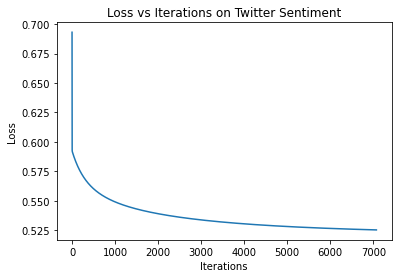

In [619]:
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations on Twitter Sentiment")
plt.plot(losses)
plt.show


In [620]:
y_pred = LogRegSent.predict(X_test_norm)

In [621]:
cm = LogRegSent.metrics(y_pred, y_test)

The confusion matrix is: 
[525, 2304]
[258, 6890]
The accuracy for the Twitter sentiment is 0.7432093815776285
The precision for the Twitter sentiment is 0.7494017837720253
The recall for the Twitter sentiment is 0.963905987688864
The F1 score for the Twitter sentiment is 0.8432260433239507


#Test 1 Additional Feature

In [622]:
def try_add_feature(x,y,feat,target):
  x_1=x
  x_1.insert(1, feat.name, feat)
  X_train, X_test, y_train, y_test = train_test_split(x_1, y, test_size=0.2, random_state=42)
  X_train_norm, X_test_norm = mms.fit_transform(X_train), mms.transform(X_test)
  feature_number, lr, epochs = X_train.shape[1], .5, 1000000
  LogRegSent = LogRegression(feature_number, lr, epochs)
  losses = LogRegSent.fit(X_train_norm, y_train)
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title("Loss vs Iterations on Twitter Sentiment")
  plt.plot(losses)
  plt.show
  y_pred = LogRegSent.predict(X_test_norm)
  cm = LogRegSent.metrics(y_pred, y_test)
  f1=(2*cm[1][1]/(cm[1][1]+cm[0][1]))*(cm[1][1]/(cm[1][1]+cm[1][0]))/((cm[1][1]/(cm[1][1]+cm[1][0]))+(cm[1][1]/(cm[1][1]+cm[0][1])))
  print("The F1 with " + str(feat.name) + " is: " + str(f1) + " but the target was: " +str(target))
  diff=target-f1
  print("The difference in F1 score with " + str(feat.name) + " is: " + str(diff))
  return diff



In [623]:
  features_selected = Xc_selected.columns
  all_features=Xc.columns
  removed_features_names=[]
  removed_features=[]
  for i in range(0,len(all_features)):
    good=0
    for j in range(0,len(features_selected)):
      if all_features[i] == features_selected[j]:
        good-=1
    if good==0:
      removed_features_names.append(Xc.columns[i])

  for k in range(0,len(removed_features_names)):
    removed_features.append(Xc[removed_features_names[k]])
    print("Adding " + str(removed_features_names[k]) + " to the removed features list")




Adding feature5 to the removed features list
Adding feature7 to the removed features list
Adding feature10 to the removed features list
Adding feature11 to the removed features list
Adding feature12 to the removed features list


The iteration is 0 and the loss is 0.6931471805599453
The iteration is 1000 and the loss is 0.5542946537131913
The iteration is 2000 and the loss is 0.5415098859948735
The iteration is 3000 and the loss is 0.5350831036105181
The iteration is 4000 and the loss is 0.5312348315069836
The iteration is 5000 and the loss is 0.528725949876204
The iteration is 6000 and the loss is 0.5270152294215463
The iteration is 7000 and the loss is 0.5258170695202251
The weight is 
[ 4.92802923 -0.31013254  1.66912248  1.51999013  1.01007324  2.79159811
  3.30597073  3.3891635 ]
The intercept is 
-9.275533542987649
The confusion matrix is: 
[515, 2314]
[269, 6879]
The accuracy for the Twitter sentiment is 0.741104540443019
The precision for the Twitter sentiment is 0.7482867399108017
The recall for the Twitter sentiment is 0.9623670956911025
The F1 score for the Twitter sentiment is 0.8419313383513861
The F1 with feature5 is: 0.8419313383513861 but the target was: 0.8089763431350873
The difference in F1 s

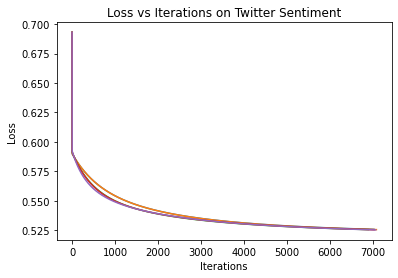

In [624]:
f1_diff_add=[]
f1_selected = 0.8089763431350873
for i in range(0,len(removed_features)):
  new=removed_features[i]
  difference=try_add_feature(Xc_selected,yc,new,f1_selected)
  f1_diff_add.append(difference)
  print("---------------")
for i in range(0,len(removed_features)):
  print("To remove " + str(removed_features[i].name) + " there was a loss of " + str(f1_diff_add[i]) + " in F1")

In [625]:
for i in range(0,len(removed_features)):
  print("To remove " + str(removed_features[i].name) + " there was a loss of " + str(f1_diff_add[i]) + " in F1")

To remove feature5 there was a loss of -0.032954995216298855 in F1
To remove feature7 there was a loss of -0.0332190922194987 in F1
To remove feature10 there was a loss of -0.0335544341050672 in F1
To remove feature11 there was a loss of -0.0335544341050672 in F1
To remove feature12 there was a loss of -0.03424970018886342 in F1


#Try 1 Remove Feature

In [670]:
def try_remove_feature(x,y,feat,target):
  x_1=x
  x_1=x_1.drop(columns=feat)
  X_train, X_test, y_train, y_test = train_test_split(x_1, y, test_size=0.2, random_state=42)
  X_train_norm, X_test_norm = mms.fit_transform(X_train), mms.transform(X_test)
  feature_number, lr, epochs = X_train.shape[1], .5, 1000000
  LogRegSent = LogRegression(feature_number, lr, epochs)
  losses = LogRegSent.fit(X_train_norm, y_train)
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.title("Loss vs Iterations on Twitter Sentiment")
  plt.plot(losses)
  plt.show
  y_pred = LogRegSent.predict(X_test_norm)
  cm = LogRegSent.metrics(y_pred, y_test)
  f1=(2*cm[1][1]/(cm[1][1]+cm[0][1]))*(cm[1][1]/(cm[1][1]+cm[1][0]))/((cm[1][1]/(cm[1][1]+cm[1][0]))+(cm[1][1]/(cm[1][1]+cm[0][1])))
  print("The F1 with " + str(feat) + " is: " + str(f1) + " but the target was: " +str(target))
  diff=target-f1
  print("The difference in F1 score without " + str(feat) + " is: " + str(diff))
  return diff



In [ ]:
all_features=Xc.columns
f1_diff_rem=[]
f1_selected = 0.8089763431350873
for i in range(0,len(all_features)):
  new=all_features[i]
  difference=try_remove_feature(Xc_selected,yc,new,f1_selected)
  f1_diff_rem.append(difference)
  print("---------------")
for i in range(0,len(all_features)):
  print("To remove " + str(all_features[i].name) + " there was a loss of " + str(f1_diff_rem[i]) + " in F1")

The iteration is 0 and the loss is 0.6931471805599453
The iteration is 1000 and the loss is 0.5534896262934913
The iteration is 2000 and the loss is 0.5458199971336917
The iteration is 3000 and the loss is 0.5422420631910059
The iteration is 4000 and the loss is 0.5401038599691866
The iteration is 5000 and the loss is 0.5386882771074364
The weight is 
[-0.71535579  0.17361531 -0.95664711  0.65020286  0.1303353   1.68789103
  1.68502729  1.27769542  3.01769152  3.43443343  3.74741856]
The intercept is 
-5.8843111287774335
The confusion matrix is: 
[417, 2412]
[198, 6950]
The accuracy for the Twitter sentiment is 0.7383983161270923
The precision for the Twitter sentiment is 0.7423627430036317
The recall for the Twitter sentiment is 0.972299944040291
The F1 score for the Twitter sentiment is 0.8419139915202907
The F1 with feature1 is: 0.8419139915202907 but the target was: 0.8089763431350873
The difference in F1 score without feature1 is: -0.03293764838520341
The iteration is 0 and the lo

#Visualizations

In [ ]:
"""
some visualization of how much the F1 difference is for each feature
order the features from best to worst with a label of each feature
that way we can try to describe why the best measured better
and why the worst measured worse
"""

#Verify our LogReg against sklearn

In [ ]:
#calling sklearn to compare. checks out my math above is correct!
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix_twitter = confusion_matrix(y_test, y_pred)
print("The confusion matrix for Twitter sentinment:")
print(confusion_matrix_twitter)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_twitter)
disp.plot()
plt.show()

In [ ]:
from sklearn import metrics 
print("The confusion matrix for Twitter sentiment:")
print(confusion_matrix_twitter)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
#I implemented it from scratch above, just using this as a benchmark to test my code. 
#My code's metrics are really really close so I consider that a win
from sklearn import metrics  
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#X=np.concatenate((X_train_norm, X_test_norm))
#y=np.concatenate((y_train, y_test))
#y.loc[y.Label == 2, 'Label'] = 1
X_train2, X_test2, y_train2, y_test2 = train_test_split(
Xc, yc, test_size=0.33, random_state=42)
#X_train2, X_test2, y_train2, y_test2 = X_train_norm, X_test_norm, y_train, y_test
goodmodel = LogisticRegression()
goodmodel.fit(X_train2, y_train2)
y_pred2 = pd.Series(goodmodel.predict(X_test2))
confusion_matrix_twitter2 = confusion_matrix(y_test2, y_pred2)
print("The confusion matrix for Twitter sentiment:")
print(confusion_matrix_twitter2)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_twitter2)
disp.plot()
plt.show()
print("Accuracy:", metrics.accuracy_score(y_test2, y_pred2))
print("Precision:", metrics.precision_score(y_test2, y_pred2))
print("Recall:", metrics.recall_score(y_test2, y_pred2))
print("F1:"), metrics.f1_score(y_test2, y_pred2)

In [ ]:
y_test2

In [ ]:
y_pred2

In [ ]:
print("Complete")

In [ ]:
# Allow about 16min for runtime
#Extract all features and put them in on data frame

def feature_extraction(data_location, label_location):
  df = pd.read_csv(data_location, header=None)
  df.columns = ['TWEET']

  df["Tweet Tokens"] = np.nan
  df["Count: Words in + Lexicon"] = np.nan
  df["Count: Words in - Lexicon"] = np.nan
  df["Contain The word NO? "] = np.nan
  df["Count: Nouns"] = np.nan
  df["Ratio: Unique Words-Total Words"] = np.nan
  df["Ratio: Stop Words-Total Words"] = np.nan
  df["Count: Adjectives in Tweet"] = np.nan
  df["Log: Tweet word count"] = np.nan
  df["Log: Length of Longest Word in Tweet"] = np.nan
  df["Log: Count of Words with 5+ Characters"] = np.nan

  # ADD LABELS COLUMN TO DF 
  labels = pd.read_csv(label_location, sep="\n", header=None)
  df = pd.concat([df,labels], axis = 1)
  df.rename(columns = {0:'Labels'}, inplace = True)

  # DROP NEUTRAL LABELS FROM DF
  df.drop(df.loc[df['Labels']==1].index, inplace=True)
  df = df.reset_index(drop=True)

  # CHANGE ALL 2 LABEL VALUES TO 1 
  for i in range(0, len(df.index)):
    if df['Labels'].values[i] == 2:
      df.at[i,'Labels'] = 1

  # CLEAN TWEETS
  pattern_a = r'[^A-Za-z0-9]+'
  pattern_b = r'\b\w{1,1}\b'
  emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)

  for i in range(0, len(df.index)):                       
    df['TWEET'].values[i] = df['TWEET'].values[i].lower()
    df['TWEET'].values[i] = df['TWEET'].values[i].replace('@user', '')
    df['TWEET'].values[i] = re.sub(pattern_a, ' ', df['TWEET'].values[i])
    df['TWEET'].values[i] = re.sub(pattern_b, '', df['TWEET'].values[i])
    df['TWEET'].values[i] = re.sub(emoji_pattern, '', df['TWEET'].values[i])

  #TOKENIZE TWEETS
  df['Tweet Tokens'] = df['Tweet Tokens'].astype('object')
  for i in range(0, len(df.index)):
    
    tokens = df['TWEET'].values[i].split()
    df.at[i, 'Tweet Tokens'] = tokens

  #Create Positive and Negative Lexicons
  pos_lexicon = []
  neg_lexicon = []

  for i in range(0, len(subreddit_dataframes)):               
    for j in range(0, len(subreddit_dataframes[i].index)):    

      if subreddit_dataframes[i]['Sentiment Score'].values[j] >= 0:         
        pos_lexicon.append(subreddit_dataframes[i]['Word'].values[j])        
      
      if subreddit_dataframes[i]['Sentiment Score'].values[j] < 0:         
        neg_lexicon.append(subreddit_dataframes[i]['Word'].values[j])        


  pos_lexicon = [*set(pos_lexicon)]   # Remove duplicate values from + lexicon
  neg_lexicon = [*set(neg_lexicon)]   # Remove duplicate values from - lexicon


  #Handle duplicate words in postitive and negative lexicon
  same_wrds = set(pos_lexicon).intersection(neg_lexicon)      #get set of all words that appear in both psoitive and Negative Lexicon
                                                              #https://stackoverflow.com/questions/1388818/how-can-i-compare-two-lists-in-python-and-return-matches

  word_vals_dict = dict.fromkeys(same_wrds, 0)                # Create a dictionary to hold of all words found in positive and negative lexicons     
  sentiment_vals2sum = []

  for k in range(0, len(same_wrds)):    # In the set of words identified in positive and negative lexicon
  
    i = same_wrds.pop()                 # i will return one word from the set, then the following with each iteration
    same_wrds.add(i)                    # https://stackoverflow.com/questions/59825/how-to-retrieve-an-element-from-a-set-without-removing-it

    sentiment_vals2sum = []             # Will store the Sentiment Scores collected across data frames 

    for j in range(0, len(subreddit_dataframes)):                    # in range of dataframes(44)
      is_wrd_there = i in subreddit_dataframes[j]['Word'].unique()   # Return true or false. True if desired word 'i' is in the data frame being checked false if not (ls_df_names[0], ls_df_names[1],...)
      if is_wrd_there is True:                              # If true... 

        mask1 = subreddit_dataframes[j]['Word'].values == i                  # Get the sentiment value of the word from its dataframe 
                                                                    # https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values
                                                      
        sentiment_vals2sum.append(subreddit_dataframes[j][mask1].iat[0,1])   # append sentiment value to list where they are stored eg. sentiment_vals2sum 
        num_avg = mean(sentiment_vals2sum)                          # Take the mean of the sentiment scores collected in the list above(these are all sentiment scores for one word collected across dataframes where the word was found 'True')
        word_vals_dict[i] = num_avg  

  # Remove words that now have a clear positive or negative classification
  for w in word_vals_dict.items():        # .items() returns a tuple of (word, score). See Cell above for all words: scores in dict
    if w[1] >= 0:                         # if w[1] (the score) is greater than 0...
      neg_lexicon.remove(w[0])            # remove it from the negative lexicon
    if w[1] < 0:                          # If w[1] (the score) is less than 0...
      pos_lexicon.remove(w[0])            # remove the word from the positive lexicon

  # COUNT POSITIVE AND NEGATIVE WORDS
  neg_lex_set = set(neg_lexicon)
  pos_lex_set = set(pos_lexicon)

  for i in range(0, len(df.index)):
    x = set(df['Tweet Tokens'][i])
    df['Count: Words in + Lexicon'].values[i] = len(x.intersection(pos_lex_set))
    df['Count: Words in - Lexicon'].values[i] = len(x.intersection(neg_lex_set))

  # DOES TWEET CONTAIN NO
  for i in range(0, len(df.index)):                       # In the range 0 to length of the tweets dataframe         # Tokenize and lowercase tweets 
    if 'no' in df['Tweet Tokens'][i]:                                    # If no is in tweet dataframe value is 1 if not value is zero
      df['Contain The word NO? '].values[i] = 1
    else: 
      df['Contain The word NO? '].values[i] = 0

  # COUNT NOUNS IN TWEET
  for i in range(0, len(df.index)):
    tokens = df['Tweet Tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    noun_definitions = ['NN', 'NNS', 'NNP', 'NNPS']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in noun_definitions:
        count += 1
    
    df['Count: Nouns'].values[i] = count    

  # RATIO: UNIQUE TO TOTAL WORDS
  for i in range(0, len(df.index)):                       
    tokens = df['Tweet Tokens'][i]
    x = np.array(tokens)
    ratio = len(np.unique(x)) / len(tokens)
    df['Ratio: Unique Words-Total Words'].values[i] = ratio    

  # STOP WORDS TO TOTAL WORDS
  for i in range(0, len(df.index)):                       
    tokens = df['Tweet Tokens'][i]
    x = np.array(tokens)
    stop_wrds_count = [w for w in tokens if w in stop_words]
    ratio = len(stop_wrds_count) / len(tokens)
    df['Ratio: Stop Words-Total Words'].values[i] = ratio

  #ADJECTIVES IN TWEET
  for i in range(0, len(df.index)):
    tokens = df['Tweet Tokens'][i]
    tokens = [w for w in tokens if not w in stop_words]
    tagged = nltk.pos_tag(tokens)

    adj_definitions = ['JJ', 'JJR', 'JJS ']
    count = 0

    for j in range(0, len(tagged)):
      if tagged[j][1] in adj_definitions:
        count += 1
    
    df['Count: Adjectives in Tweet'].values[i] = count

  # LOG OF TWEET WORD COUNT 
  for i in range(0, len(df.index)):           #In range: length of dataframe of tweets
    tokens = df['Tweet Tokens'][i]       #tokenize tweets 
    log_val = math.log(len(tokens))
    df['Log: Tweet word count'].values[i] = log_val


  # LOG LENGTH OF LONGEST WORD IN TWEET
  for i in range(0, len(df.index)):           #In range: length of dataframe of tweets
    tokens = df['Tweet Tokens'][i]   #tokenize tweets 
    longest_wrd = max(tokens, key=len)
    log_val =  math.log(len(longest_wrd))
    df['Log: Length of Longest Word in Tweet'].values[i] = log_val

  #LOG OF COUNT OF WORD WITH 5+ CHARACTERS
  for i in range(0, len(df.index)):           #In range: length of dataframe of tweets
    tokens = df['Tweet Tokens'][i]    #tokenize tweets
    count = 0
      
    if any(len(i) >= 5 for i in tokens) is True:

      for j in range(0, len(tokens)):
        if len(tokens[j]) >= 5:
          count = count +1

      log_val = math.log(count)
      df['Log: Count of Words with 5+ Characters'].values[i] = log_val
      
    else:
      df['Log: Count of Words with 5+ Characters'].values[i] = 0


  return(df)

In [ ]:
#How to run: 
# dataframe = feature_extraction(data_location, label_location)